In [145]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
# from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def get_L99(y,utilde,plotOpt=False):
    utop = 0.99*inp.du/2
    ubot = -0.99*inp.du/2
    ibot = np.argmin(abs(utilde[Ny/2:]-utop)[::-1])
    itop = np.argmin(abs(utilde[:Ny/2]-ubot)[::-1])+Ny/2
    L99 = y[itop]-y[ibot]
    if plotOpt:
        plt.plot(y,utilde)
        #plt.plot(y[:Ny/2],utilde[:Ny/2],'--')
        #plt.plot(y[Ny/2:],utilde[Ny/2:],'--')
        plt.plot([y[ibot],y[ibot]],[-inp.du/2.,inp.du/2.],'k:',label='bot')
        plt.plot([y[itop],y[itop]],[-inp.du/2.,inp.du/2.],'k--',label='top')
        plt.legend()
    return L99,itop,ibot

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    R11 = dat[:,0]
    R12 = dat[:,1]
    R13 = dat[:,2]
    R22 = dat[:,3]
    R23 = dat[:,4]
    R33 = dat[:,5]
    return R11,R12,R13,R22,R23,R33

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)
dy = abs(y[0]-y[1])

flist = glob.glob(directory+"*vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.8
	Re = 1000.0
	rr = 0.1428571429
Params for this grid:
	N = 1024x1448x512
	L = 100.0x125.0x50.0
['shearlayer_lscale_vv_0004.dat', 'shearlayer_lscale_vv_0005.dat', 'shearlayer_lscale_vv_0006.dat', 'shearlayer_lscale_vv_0007.dat', 'shearlayer_lscale_vv_0008.dat']


0.8:[0.209012269376,0.0119049585554]
(0.8, 0.1428571429)


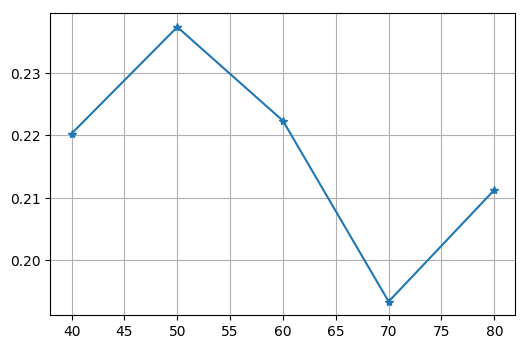

In [146]:
# Integrated profiles
# 1D integration in y using midpoint rule:

def get_Mg(directory,flist):
    mat = np.zeros([len(flist),2])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get centerline
        ic,yc = get_centerline(directory,y,tID)
         
        # Get integral lengthscale
        dat = np.fromfile(directory+'shearlayer_lscale_vv_%04d'%(tID)+'.dat',dtype=float,sep=' ')
        autocorr = np.fft.fftshift(dat)
        L_int = get_lscale(y,autocorr)
        
        # Get shear S
        utilde = np.fromfile(directory+'shearlayer_utilde_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        offset = 2
        i1 = ic-offset
        i2 = ic+offset
        dy = y[i1]-y[i2]
        S = (utilde[i1]-utilde[i2])/dy  
        
        # Get cbar
        cbar = np.fromfile(directory+'shearlayer_cbar_%04d'%(tID)+'.dat', sep=' ')
        
        # Record for later
        mat[i,0] = time
        mat[i,1] = S*L_int/max(cbar)
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]


fig = plt.figure(dpi=100)
dat = get_Mg(directory,flist[:])
plt.grid(True)
# plt.xlim([-20,20])
plt.plot(dat[:,0],dat[:,1],'-*')
print('{}:[{},{}]'.format(inp.Mc,np.mean(dat[-3:,1]),np.std(dat[-3:,1])))
print(inp.Mc,inp.rr)

0.2:[0.260926671034,0.235099224825],
0.8:[0.440111326524,0.0315268911625],
2.0:[0.815797081164,0.0175500462521],


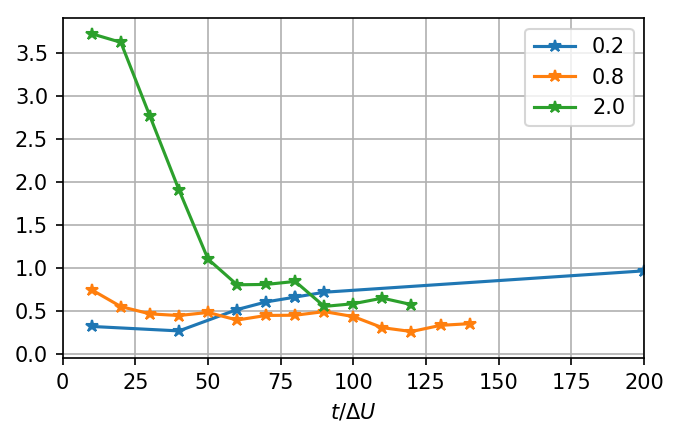

In [131]:
s = '7'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"*lscale_vv*")
    flist.sort()

    # Plot Rij
    dat = get_Mg(directory,flist)
    t = dat[:,0]
    f = dat[:,1]
    plt.plot(t,f,'-*',label='{}'.format(inp.Mc))
    
    idx = 5
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:-4]),np.std(f[idx:-4])))
    
plt.grid(True)
plt.legend()
plt.xlabel(r'$t/\Delta U$')
plt.xlim([0,200])
plt.savefig('/home/kmatsuno/ShearLayer_img/vs_t/'+'Mg_s%s'%s,dpi=200,bbox_inches='tight')

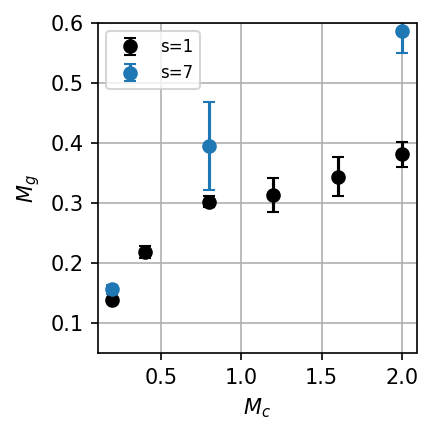

In [143]:
Mg_s7 = {
0.2:[0.156667003692,0.00784940390754],
0.8:[0.440111326524,0.0315268911625],
2.0:[0.58648688731,0.0359992747966],
}
Mg_s_7 = {
0.2:[0.0723795746931,0.00116980981762],
0.8:[0.202354825487,0.0089234175017],
2.0:[0.318567387574,0.0509824170665],
}
Mg = {
0.2:[0.138292050729,0.00413351311654],
0.4:[0.218778504571,0.00954186563977],
0.8:[0.302877483488,0.00957521930583],
1.2:[0.314125139833,0.0287442038449],
1.6:[0.344064761114,0.0321712104234],
2.0:[0.381198747564,0.0201273664808],
}
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)

fig = plt.figure(figsize=(3,3),dpi=150)
s1 = Mg
s7 = Mg_s7#merge_dicts(Mt_s7,Mt_s_7)
plotter(s1,'s=1','ko')
plotter(s7,'s=7','o')

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$M_{g}$')
plt.legend(fontsize=8)
# plt.xlim([0,2.1])
plt.ylim([0.05,0.6])
plt.tight_layout()
# plt.savefig('/home/kmatsuno/ShearLayer_img/Mg.png',dpi=200, bbox_inches='tight')